In [1]:
# Political Pole Detector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# This helps turn .txt files into Excel files .xlsx or CSV files (if you're lucky)
# If files aren't cooperative...run this code then copy and paste the dates into column one
# and articles into column two in Excel, then save as an Excel file.

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            date = line
#            date = date[0:12]
#            with open('csvs/NewsMax.txt', 'a+', encoding='utf-8') as s:
#                s.write(date + "\n")

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            article = line
#            article = article[12:]
#            with open('csvs/NewsMax2.txt', 'a+', encoding='utf-8') as s:
#                s.write(article)

In [3]:
# Let's see what features we have.

# Character length requirement for articles
length_req = 800

left = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left.shape[0]))

for x in range(left.shape[0]):
    if len(left['article'][x]) < length_req:
        left.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left.shape[0], length_req))

# Only keep the unique article rows and their values
left.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left.shape[0]))

left['date'] = left['date'].str.replace(',', '')

left.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [4]:
# Let's see what features we have.
right = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right.shape[0]))

#count = right.shape[0]

for x in range(right.shape[0]):
    if len(right['article'][x]) < length_req:
        right.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right.shape[0], length_req))

# Only keep the unique rows and their values
right.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right.shape[0]))

right['date'] = right['date'].str.replace(',', '')

right.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [5]:
# Check for null values
right.isnull().sum(axis=0)

date       15
article     0
dtype: int64

In [6]:
left.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [7]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [8]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [9]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)

all_data = pd.concat([left, right]) # combine left and right datasets
column_names = all_data.columns.values
all_data.columns = column_names
all_data = all_data.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data['date'] = all_data['date'].str.replace(',', '')
all_data.head()

We have 4,304 left-wing records
We have 5,588 right-wing records
Getting random sample of right-wing records


,date,article,pole
0,2020-04-16,Peter Navarro: WHO Has 'Blood on Their Hands' ...,1
1,2020-03-06,Pompeo: US Won't Let International Criminal Co...,1
2,2020-05-01,"Rep. Swalwell: Biden, Reade Both Have Right to...",1
3,2020-02-18,Stephen Miller’s Uncle Donates To Pro-Refugee ...,0
4,2020-05-28,Trump: Would Love to 'Get Rid of My Whole Twit...,1


In [10]:
print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

# Only keep the unique rows and their values
all_data.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

4,304 / 8,608 Current Records
8,608 Records are unique
4,304 / 8,608 Current Records


In [11]:
# Save the rows used from notspam to a CSV.
# Can give you a good idea of what constitutes a good set of data
# when a run results in high accuracy.
#notspam.to_csv(r'positive.csv')
#spam.to_csv(r'negative.csv')

# We can see there's some strange html characters present.
# Very important to cast the entire column as a string type first, so some of these numeric values come in as strings.
# Otherwise, the row values for these comments where they're present will turn into NaN values.
#all_data['article'] = all_data['article'].astype(str).str.replace(r'&#39;', "\'").astype('string')

# This is a more clean and thorough url decoding function for decoding any character string...
all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))

In [12]:
# Store the original comments in a new column
all_data['unfiltered_articles'] = all_data['article'].values
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-16,Peter Navarro: WHO Has 'Blood on Their Hands' ...,1,Peter Navarro: WHO Has 'Blood on Their Hands' ...
1,2020-03-06,Pompeo: US Won't Let International Criminal Co...,1,Pompeo: US Won't Let International Criminal Co...
2,2020-05-01,"Rep. Swalwell: Biden, Reade Both Have Right to...",1,"Rep. Swalwell: Biden, Reade Both Have Right to..."
3,2020-02-18,Stephen Miller’s Uncle Donates To Pro-Refugee ...,0,Stephen Miller’s Uncle Donates To Pro-Refugee ...
4,2020-05-28,Trump: Would Love to 'Get Rid of My Whole Twit...,1,Trump: Would Love to 'Get Rid of My Whole Twit...


In [13]:
# Clean the text
# The apostrophes here are very specific.
# The regular ' will not work from keyboard.
# You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
all_data['article'] = all_data['article'].str.lower()
all_data['article'] = all_data['article'].str.replace(r"u.s.", "united states")
all_data['article'] = all_data['article'].str.replace(r"what’s", "what is")
all_data['article'] = all_data['article'].str.replace(r"’s", " ")
all_data['article'] = all_data['article'].str.replace(r"’ve", "have")
all_data['article'] = all_data['article'].str.replace(r"’re", "are")
all_data['article'] = all_data['article'].str.replace(r"’ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can’t", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren’t", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn’t", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn’t", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn’t", "does not")
all_data['article'] = all_data['article'].str.replace(r"don’t", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn’t", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn’t", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven’t", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn’t", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn’t", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn’t", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren’t", "were not")
all_data['article'] = all_data['article'].str.replace(r"won’t", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn’t", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn’t", "must not")
all_data['article'] = all_data['article'].str.replace(r"i’m", "i am")

# As are these apostrophes...
all_data['article'] = all_data['article'].str.replace(r"what's", "what is")
all_data['article'] = all_data['article'].str.replace(r"'s", " ")
all_data['article'] = all_data['article'].str.replace(r"'ve", "have")
all_data['article'] = all_data['article'].str.replace(r"'re", "are")
all_data['article'] = all_data['article'].str.replace(r"'ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can't", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren't", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn't", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn't", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn't", "does not")
all_data['article'] = all_data['article'].str.replace(r"don't", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn't", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn't", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven't", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn't", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn't", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn't", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren't", "were not")
all_data['article'] = all_data['article'].str.replace(r"won't", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn't", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn't", "must not")
all_data['article'] = all_data['article'].str.replace(r"i'm", "i am")
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-16,peter navarro: who has 'blood on their hands' ...,1,Peter Navarro: WHO Has 'Blood on Their Hands' ...
1,2020-03-06,pompeo: us will not let international criminal...,1,Pompeo: US Won't Let International Criminal Co...
2,2020-05-01,"rep. swalwell: biden, reade both have right to...",1,"Rep. Swalwell: Biden, Reade Both Have Right to..."
3,2020-02-18,stephen miller uncle donates to pro-refugee g...,0,Stephen Miller’s Uncle Donates To Pro-Refugee ...
4,2020-05-28,trump: would love to 'get rid of my whole twit...,1,Trump: Would Love to 'Get Rid of My Whole Twit...


In [14]:
# Custom word removal - these appear too frequently and do not help with generalization.
custom = {'donald j trump', 'donald john trump', 'donald j. trump', 'newsmax', "huffpost", "___", "donald trump", "trump", "pelosi"}

# Did not work
#for word in custom:
#    all_data["article"]= all_data["article"].replace(word, " ") 

# Did not work
#all_data['article'] = all_data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

# Did work
#def customWord(text):
#    custom = {'donald j trump', 'donald john trump', 'donald j. trump', "huffpost", "newsmax"}
#    return text.replace("huffpost", " ") 

for word in custom:
    all_data['article'] = all_data['article'].apply(lambda x: x.replace(word, " "))
    
# Check to see the words were replaced
all_data[all_data['article'].str.contains("newsmax")]

,date,article,pole,unfiltered_articles


In [15]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

all_data['article'] = all_data['article'].apply(lambda x: remove_years(x))
all_data.head()

# Punctuation removal - CountVectorizer() does this for you
#punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

,date,article,pole,unfiltered_articles
0,2020-04-16,peter navarro: who has 'blood on their hands' ...,1,Peter Navarro: WHO Has 'Blood on Their Hands' ...
1,2020-03-06,pompeo: us will not let international criminal...,1,Pompeo: US Won't Let International Criminal Co...
2,2020-05-01,"rep. swalwell: biden, reade both have right to...",1,"Rep. Swalwell: Biden, Reade Both Have Right to..."
3,2020-02-18,stephen miller uncle donates to pro-refugee g...,0,Stephen Miller’s Uncle Donates To Pro-Refugee ...
4,2020-05-28,: would love to 'get rid of my whole twitter ...,1,Trump: Would Love to 'Get Rid of My Whole Twit...


In [16]:
all_data[all_data['article'].str.contains("19")]

,date,article,pole,unfiltered_articles


### One-gram - Stopword removal and no lemmatization

In [17]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.809079
883429.5641ms
Confusion Matrix:
[[705 148]
 [190 679]]
Accuracy Score : 0.8037166085946573
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.83      0.81       853
       Right       0.82      0.78      0.80       869

    accuracy                           0.80      1722
   macro avg       0.80      0.80      0.80      1722
weighted avg       0.80      0.80      0.80      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.827507
486613.09089999995ms
Confusion Matrix:
[[726 159]
 [144 693]]
Accuracy Score : 0.8240418118466899
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.82      0.83       885
       Right       0.81      0.83      0.82       837

    accuracy                           0.82      1722
   macro avg       0.82      0.82      0.82      1722
weighted avg       0.82      0.82      0.82      1722

LinearSVC Acc

### Voteclassifier - Stopword removal and no lemmatization

In [18]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.852226
1222862.3766ms
Confusion Matrix:
[[727 117]
 [166 712]]
Accuracy Score : 0.8356562137049942
Report : 
              precision    recall  f1-score   support

        Left       0.81      0.86      0.84       844
       Right       0.86      0.81      0.83       878

    accuracy                           0.84      1722
   macro avg       0.84      0.84      0.84      1722
weighted avg       0.84      0.84      0.84      1722



In [19]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [20]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [21]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_onegram_sr_nol_nopr.pkl')

['h_and_n_onegram_sr_nol_nopr.pkl']

### Bi-gram - Stopword removal and no lemmatization

In [22]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.808188
1100695.6836999997ms
Confusion Matrix:
[[675 177]
 [181 689]]
Accuracy Score : 0.7921022067363531
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.79      0.79       852
       Right       0.80      0.79      0.79       870

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.829346
821840.7675999997ms
Confusion Matrix:
[[692 140]
 [156 734]]
Accuracy Score : 0.8281068524970964
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.83      0.82       832
       Right       0.84      0.82      0.83       890

    accuracy                           0.83      1722
   macro avg       0.83      0.83      0.83      1722
weighted avg       0.83      0.83      0.83      1722

LinearS

### Voteclassifier - Stopword removal and no lemmatization

In [23]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.857704
1738446.6384999997ms
Confusion Matrix:
[[754 103]
 [138 727]]
Accuracy Score : 0.8600464576074333
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.88      0.86       857
       Right       0.88      0.84      0.86       865

    accuracy                           0.86      1722
   macro avg       0.86      0.86      0.86      1722
weighted avg       0.86      0.86      0.86      1722



In [24]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [25]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [26]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_bigram_sr_nol_nopr.pkl')

['h_and_n_bigram_sr_nol_nopr.pkl']

### Tri-gram - Stopword removal and no lemmatization

In [27]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.804472
1415065.2984999998ms
Confusion Matrix:
[[678 154]
 [173 717]]
Accuracy Score : 0.8101045296167247
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.81      0.81       832
       Right       0.82      0.81      0.81       890

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.829481
1054221.5587000009ms
Confusion Matrix:
[[701 145]
 [141 735]]
Accuracy Score : 0.8339140534262486
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.83      0.83       846
       Right       0.84      0.84      0.84       876

    accuracy                           0.83      1722
   macro avg       0.83      0.83      0.83      1722
weighted avg       0.83      0.83      0.83      1722

Linear

### Voteclassifier - Stopword removal and no lemmatization

In [28]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.856543
1841976.388700001ms
Confusion Matrix:
[[720 133]
 [111 758]]
Accuracy Score : 0.8583042973286876
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.84      0.86       853
       Right       0.85      0.87      0.86       869

    accuracy                           0.86      1722
   macro avg       0.86      0.86      0.86      1722
weighted avg       0.86      0.86      0.86      1722



In [29]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [30]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [31]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_trigram_sr_nol_nopr.pkl')

['h_and_n_trigram_sr_nol_nopr.pkl']

In [32]:
# Lemmatization after Word Tokenization
# Higher accuracy and recall consistently resulted from no lemmatization as opposed to lemmatization.
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

lemmatizer = WordNetLemmatizer()
all_data['article'] = all_data.article.apply(lemmatize_text)
all_data.head()

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
7575,2020-04-27,ny paper blast aoc for 'terribly wrong ' vote ...,1,NY Paper Blasts AOC for 'Terribly Wrong' Vote ...
6563,2020-04-03,‘ the beast come at night ’ : chris cuomo reve...,0,‘The Beast Comes At Night’: Chris Cuomo Reveal...
3845,2020-06-11,sen. cotton : reject 'woke mob ' painting u a ...,1,Sen. Cotton: Reject 'Woke Mob' Painting US as ...
3901,2020-01-22,united state to impose visa restriction for pr...,0,U.S. To Impose Visa Restrictions For Pregnant ...
436,2020-01-31,john kelly : impeach trial without witness 'ha...,1,John Kelly: Impeach Trial Without Witnesses 'H...


### One-gram - Stopword removal and lemmatization

In [33]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.797696
762653.8235000008ms
Confusion Matrix:
[[650 188]
 [139 745]]
Accuracy Score : 0.8101045296167247
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.78      0.80       838
       Right       0.80      0.84      0.82       884

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.819919
417599.28240000224ms
Confusion Matrix:
[[664 175]
 [129 754]]
Accuracy Score : 0.8234610917537747
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.79      0.81       839
       Right       0.81      0.85      0.83       883

    accuracy                           0.82      1722
   macro avg       0.82      0.82      0.82      1722
weighted avg       0.82      0.82      0.82      1722

LinearS

### Voteclassifier - Stopword removal and lemmatization

In [34]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.844270
1243729.8213000032ms
Confusion Matrix:
[[709 139]
 [125 749]]
Accuracy Score : 0.8466898954703833
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.84      0.84       848
       Right       0.84      0.86      0.85       874

    accuracy                           0.85      1722
   macro avg       0.85      0.85      0.85      1722
weighted avg       0.85      0.85      0.85      1722



In [35]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [36]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [37]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_onegram_sr_l_nopr.pkl')

['h_and_n_onegram_sr_l_nopr.pkl']

### Bi-gram - Stopword removal and lemmatization

In [38]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.791405
1167175.1337000025ms
Confusion Matrix:
[[703 175]
 [179 665]]
Accuracy Score : 0.794425087108014
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.80      0.80       878
       Right       0.79      0.79      0.79       844

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.822125
825821.0658999997ms
Confusion Matrix:
[[712 165]
 [133 712]]
Accuracy Score : 0.826945412311266
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.81      0.83       877
       Right       0.81      0.84      0.83       845

    accuracy                           0.83      1722
   macro avg       0.83      0.83      0.83      1722
weighted avg       0.83      0.83      0.83      1722

LinearSVC

### Voteclassifier - Stopword removal and lemmatization

In [39]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.847813
2120545.639300006ms
Confusion Matrix:
[[739 159]
 [106 718]]
Accuracy Score : 0.8461091753774681
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.82      0.85       898
       Right       0.82      0.87      0.84       824

    accuracy                           0.85      1722
   macro avg       0.85      0.85      0.85      1722
weighted avg       0.85      0.85      0.85      1722



In [40]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [41]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [42]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_bigram_sr_l_nopr.pkl')

['h_and_n_bigram_sr_l_nopr.pkl']

### Tri-gram - Stopword removal and lemmatization

In [43]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.787940
1782563.395600002ms
Confusion Matrix:
[[666 183]
 [179 694]]
Accuracy Score : 0.7897793263646922
Report : 
              precision    recall  f1-score   support

        Left       0.79      0.78      0.79       849
       Right       0.79      0.79      0.79       873

    accuracy                           0.79      1722
   macro avg       0.79      0.79      0.79      1722
weighted avg       0.79      0.79      0.79      1722

Logistic Regression Accuracy Score averaged over 30 runs: 0.821854
1404140.2076999948ms
Confusion Matrix:
[[675 193]
 [141 713]]
Accuracy Score : 0.8060394889663183
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.78      0.80       868
       Right       0.79      0.83      0.81       854

    accuracy                           0.81      1722
   macro avg       0.81      0.81      0.81      1722
weighted avg       0.81      0.81      0.81      1722

LinearS

### Voteclassifier - Stopword removal and lemmatization

In [44]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.846748
2482230.4428999997ms
Confusion Matrix:
[[717 160]
 [108 737]]
Accuracy Score : 0.8443670150987224
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.82      0.84       877
       Right       0.82      0.87      0.85       845

    accuracy                           0.84      1722
   macro avg       0.85      0.84      0.84      1722
weighted avg       0.85      0.84      0.84      1722



In [45]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [46]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [47]:
# Let's save our model
joblib.dump(text_clf, 'h_and_n_trigram_sr_l_nopr.pkl')

['h_and_n_trigram_sr_l_nopr.pkl']

In [48]:
# This just makes sure the below functions work for seeing
# words that are used as features to detect spam comments.
# It does not retrain the model. That was saved in final_model.
train, test = train_test_split(all_data, test_size=0.2)

# Changing this to n_gram(1,2) may be all you need to do to see some of the top bigrams.
count_vect = CountVectorizer(min_df = 4, max_df = .75, stop_words='english', ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train.article)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

clf = SGDClassifier().fit(X_train_tfidf, train.pole)

In [49]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(count_vect, clf, 40)

		Left           			Right          
	-4.3478	ap             		3.8152	hill           
	-3.0489	covid          		2.9156	healthcare     
	-3.0004	check          		2.9078	report         
	-2.8694	washington ap  		2.5558	dems           
	-2.8621	reportedly     		2.5164	according      
	-2.7062	claimed        		2.0721	politico       
	-2.6731	twitter        		1.9516	ny             
	-2.6100	suggested      		1.8289	democrat       
	-2.5905	twitter user   		1.7546	tweeted        
	-2.5225	warned         		1.6827	hill reported  
	-2.4735	host           		1.6164	according hill 
	-2.4187	month          		1.5960	dem            
	-2.3822	progressive    		1.5676	cbs            
	-2.3113	year           		1.5185	cbs news       
	-2.2466	later          		1.5172	virus          
	-2.1773	user           		1.4944	axios          
	-2.0884	video          		1.4675	wh             
	-1.9135	repeatedly     		1.4646	aoc            
	-1.8681	apparently     		1.4131	ch             
	-1.8408	health care    		1.3943	

In [50]:
# Shows you the most frequently occurring words seen in text labelled as right.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['right'], 50)

right: republican president, liberal, wa used report, democratic party presidential, illegal, crenshaw, police custody, said said, federal agent, percent, told fox news, integrity, news report, discunited, according cnn, york post, new york post, used report, news fox, fox news fox, obligation, morning, mike bloomberg, tweet, told fox, schumer, ny time, convention, reported, riot, news fox friend, ch, aoc, wh, axios, virus, cbs news, cbs, dem, according hill, hill reported, tweeted, democrat, ny, politico, according, dems, report, healthcare, hill


In [51]:
# Shows you the most frequently occurring words seen in text labelled as left.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['left'], 50)

left: ap, covid, check, washington ap, reportedly, claimed, twitter, suggested, twitter user, warned, host, month, progressive, year, later, user, video, repeatedly, apparently, health care, critic, failed, new, initially, clip, expert, democratic, live, reporter, zelensky, claiming, website, check clip, previously, explained, amid, called, sunday, disease, asked, writer, guide coronavirus, coronavirus, racist, meant, public, guide, confirmed, reelection, editorial


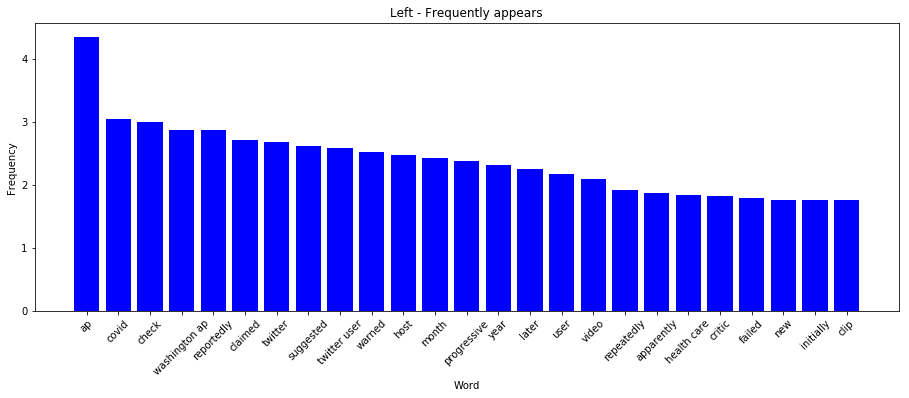

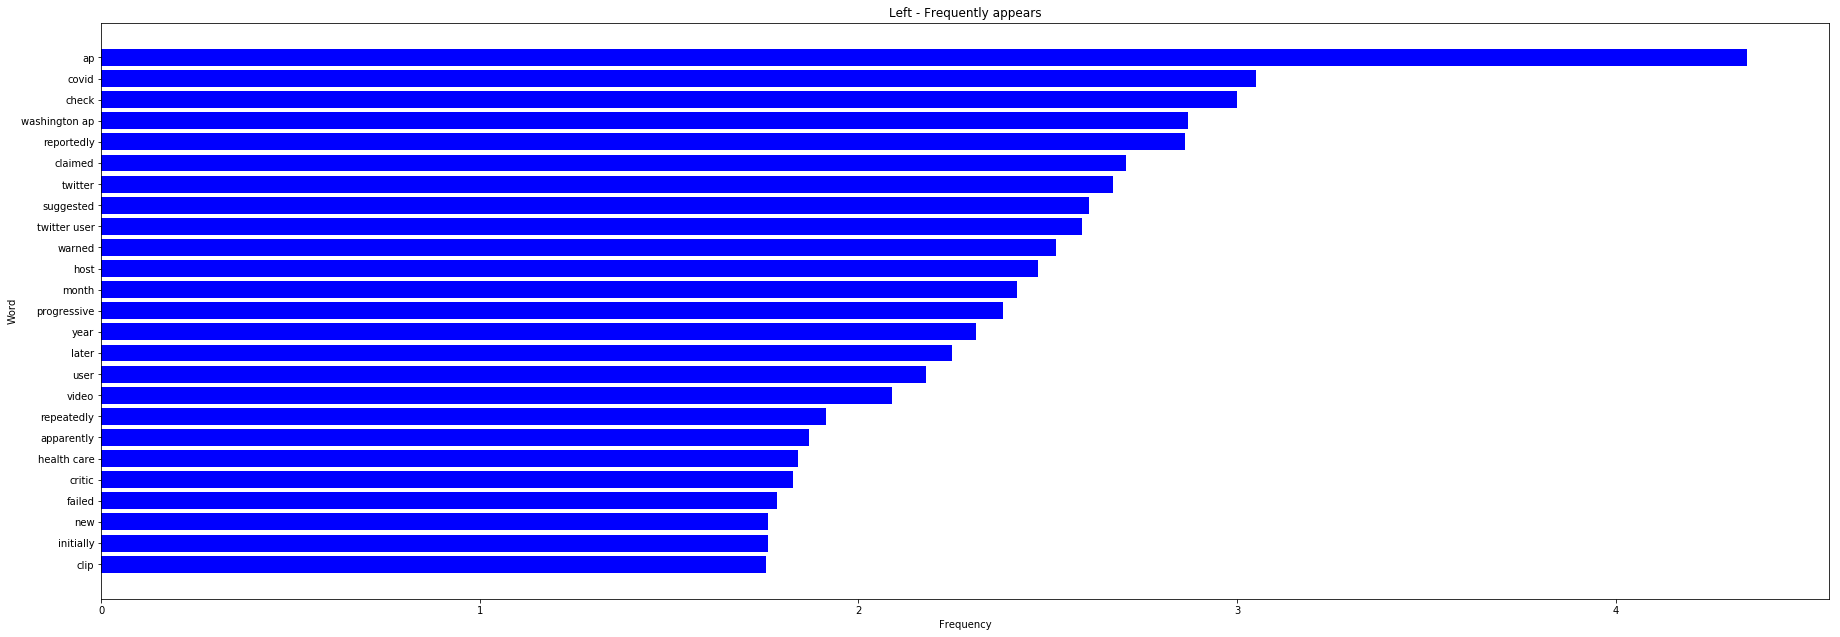

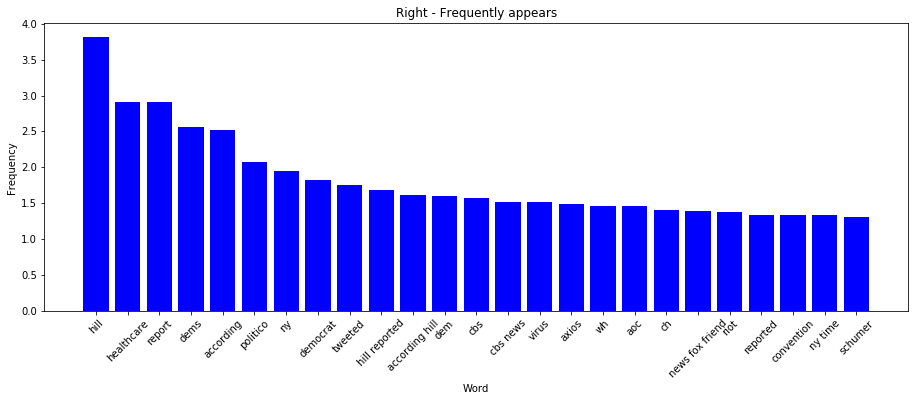

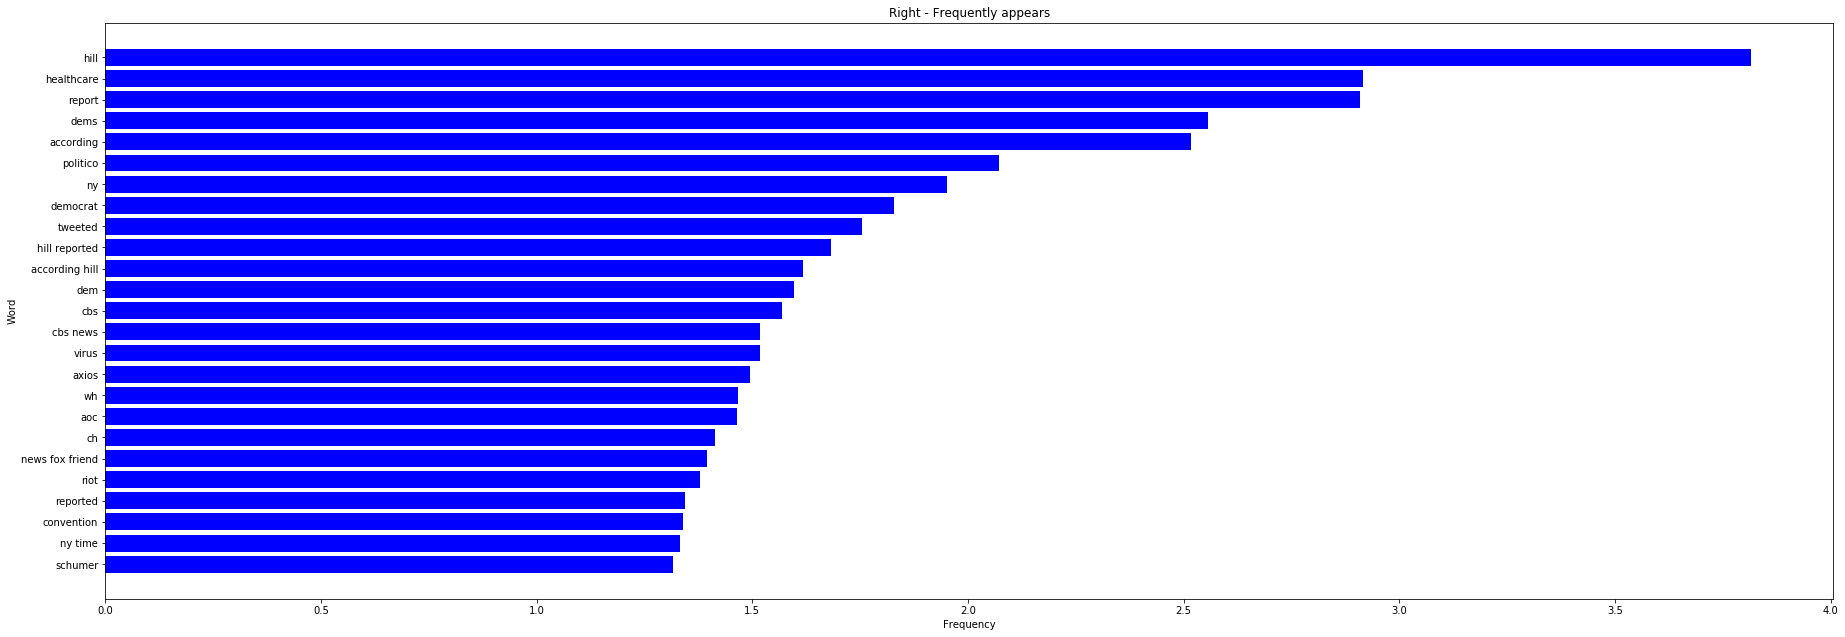

In [52]:
# Plot the most frequently occurring words seen in text labelled as right or left
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def plot_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.bar(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Left - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.barh(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Left - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.bar(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Right - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.barh(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Right - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
plot_most_informative_features(count_vect, clf, 25)

In [53]:
#print(count_vect.get_feature_names())

In [54]:
# Let's save our model
#joblib.dump(text_clf, 'pipeline.pkl')

Confusion Matrix:
[[4014  290]
 [ 186 4118]]
Accuracy Score : 0.9447026022304833
Report : 
              precision    recall  f1-score   support

       Right       0.96      0.93      0.94      4304
        Left       0.93      0.96      0.95      4304

    accuracy                           0.94      8608
   macro avg       0.94      0.94      0.94      8608
weighted avg       0.94      0.94      0.94      8608

             Confusion Matrix


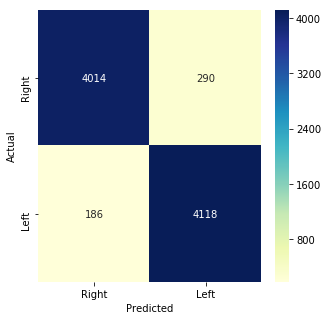

Classification Error of: 0.055297397769516726
95% Confidence Interval of: [0.050468979936912406, 0.06012581560212105]
Left = 0, Right = 1 

Predicted: 0 Actual: 1
Peter Navarro: WHO Has 'Blood on Their Hands' The World Health Organization has "blood on their hands" over its handling of the coronavirus pandemic and its early denial that the virus could not be spread between people, White House trade adviser Peter Navarro said. Navarro was on Fox Business Network's "Lou Dobbs Tonight" Wednesday and accused the WHO and its director-general Dr. Tedros Adhanom Ghebreyesus of siding with China. After referencing the "slaughter of tens of thousands of people around the world" due to the COVID-19 virus, Navarro said that on Jan. 14, "the World Health Organization was once again denying human-to-human transmission, even though Taiwan had told them there was such evidence of that two weeks earlier. "And you know and I know, Lou, that it was because China was able to exert pressure on their puppe

Highest performing classifier: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])


In [55]:
# End Results - Load the model and let's see the end results
text_clf = joblib.load('h_and_n_onegram_sr_l_nopr.pkl')
predicted = text_clf.predict(all_data.unfiltered_articles)
#print(metrics.classification_report(test.pole, predicted, target_names=["NotSpam", "Spam"]))
tn, fp, fn, tp = metrics.confusion_matrix(all_data.pole, predicted).ravel()
results = metrics.confusion_matrix(all_data.pole, predicted)
#print((tn, fp, fn, tp))
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', metrics.accuracy_score(all_data.pole, predicted))
print('Report : ')
print(metrics.classification_report(all_data.pole, predicted, target_names=["Right", "Left"]))


print("             Confusion Matrix")
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(results, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=["Right","Left"], yticklabels=["Right","Left"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Error
incorrect_predictions = fp + fn
total_predictions = tp + tn + fp + fn
classification_error = incorrect_predictions / total_predictions
print("Classification Error of:",classification_error)

# 95% Confidence Interval (const: 1.96)
# There is a 95% likelihood that the confidence interval [0.xx, 0.xx] 
# covers the true classification error of the model on unseen data.
confidence_interval = []
confidence_interval.append(classification_error - 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
confidence_interval.append(classification_error + 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
print("95% Confidence Interval of:",confidence_interval)

# Let's see some examples of how the model and original dataset is classifying text.
print("Left = 0, Right = 1 \n")
for x in range(5):
    print("Predicted:", predicted[x], end=" ")
    print("Actual:", all_data['pole'][x])
    print(all_data['unfiltered_articles'][x], end="\n\n")

print("Highest performing classifier:", text_clf)

In [56]:
# Write results to results.txt for the entire notebook's run.
acc = metrics.accuracy_score(all_data.pole, predicted)
acc = "Entire dataset accuracy: " + str(acc) + "\n"
f = open('results.txt', 'a+')
f.write(acc)
f.close()

In [64]:
for model, acc in final_model:
    print(acc)

0.787940379403794
0.8218544328300424
0.833468834688347
0.8481416957026716
0.7102013162988772
0.7520131629887729
0.8287650019357337
0.8467479674796748


In [65]:
for x in range(len(final_model)):
    print(final_model[x])

[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=0))]), 0.787940379403794]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))]), 0.8218544328300424]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0)))]), 0.833468834688347]
[Pipeline(steps=[('vect',
     

In [67]:
print(text_clf)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=0))])
